In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical

%matplotlib inline

DATA_DIR='/kaggle/input/8-facial-expressions-for-yolo/9 Facial Expressions you need'
train = os.listdir(os.path.join(DATA_DIR,'train'))
test = os.listdir(os.path.join(DATA_DIR,'test'))
val=os.listdir(os.path.join(DATA_DIR,'valid'))
print(f'Train - {train}')
print(f'Test - {test}')
print(f'Val - {val}')

IMG_SIZE = 48
EMOTIONS = ['Happy', 'Sad', 'Angry', 'Surprised', 'Neutral', 'Disgusted', 'Fear', 'Sleepy', 'Contempt']  # update based on your labels
emotion_to_idx = {e: i for i, e in enumerate(EMOTIONS)}
idx_to_emotion = {i: e for i, e in enumerate(EMOTIONS)} # Add mapping from index to emotion

def load_data(folder_path):
    image_dir = os.path.join(folder_path, 'images')
    label_dir = os.path.join(folder_path, 'labels')

    images = []
    labels = []

    # Get list of label files
    label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.txt')])

    for label_fname in label_files:
        image_fname = label_fname.replace('.txt', '.jpg')
        image_path = os.path.join(image_dir, image_fname)
        label_path = os.path.join(label_dir, label_fname)

        # Check if the corresponding image file exists
        if not os.path.exists(image_path):
            print(f"Warning: Image file not found for label file {label_path}. Skipping.")
            continue

        # Load image in grayscale
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: Could not read image file {image_path}. Skipping.")
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to 48×48
        images.append(img)

        # Load and parse label from YOLO format
        with open(label_path, 'r') as f:
            label_content = f.read().strip()
            # Assuming the first number in the line is the class ID
            try:
                class_id = int(label_content.split()[0])
                labels.append(class_id)
            except (ValueError, IndexError):
                print(f"Warning: Could not parse label from file {label_path}. Content: '{label_content}'. Skipping.")
                images.pop() # Remove the image if label parsing fails
                continue


    images = np.array(images)
    labels = np.array(labels)
    return images, labels
     

# Load full data from train folder
images, labels = load_data(os.path.join(DATA_DIR, 'test'))

# Normalize pixel values to be between 0 and 1
images = images / 255.0


# Reduce dataset size
n_train = 10000
n_test = 4000

train_images = images[:]
train_labels = labels[:]
test_images = images[-n_test:]
test_labels = labels[-n_test:]

# Add grayscale channel dimension: (N, 48, 48, 1)
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

# One-hot encode the labels
train_labels_categorical = to_categorical(train_labels, num_classes=len(EMOTIONS))
test_labels_categorical = to_categorical(test_labels, num_classes=len(EMOTIONS))

# Final checks
print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Train labels shape: {train_labels_categorical.shape}")
print(f"Test labels shape: {test_labels_categorical.shape}")

2025-08-26 15:01:32.099828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756220492.314610      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756220492.381641      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Train - ['labels', 'images']
Test - ['labels', 'images']
Val - ['labels', 'images']
Train images shape: (1700, 48, 48, 1)
Test images shape: (1700, 48, 48, 1)
Train labels shape: (1700, 9)
Test labels shape: (1700, 9)


In [3]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.image import resize
import numpy as np

# ----------------- Data Augmentation -----------------
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# ----------------- Preprocess for EfficientNet -----------------
def prepare_for_efficientnet(images):
    resized = np.array([resize(img, (224,224)).numpy() for img in images])
    if resized.shape[-1] == 1:  # grayscale to RGB
        resized = np.repeat(resized, 3, axis=-1)
    return resized

train_images_eff = prepare_for_efficientnet(train_images)
test_images_eff = prepare_for_efficientnet(test_images)

print("Train shape:", train_images_eff.shape)
print("Test shape:", test_images_eff.shape)

# ----------------- Build EfficientNetB0 Model -----------------
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    verbose=1,
    restore_best_weights=True
)
lr_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    mode='max',
    verbose=1,
    factor=0.1,
    min_lr=1e-5
)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze EfficientNet backbone

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(EMOTIONS), activation='softmax')  # match number of classes
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# ----------------- Training -----------------
batch_size = 32
epochs = 30  # transfer learning usually converges faster

history = model.fit(
    datagen.flow(train_images_eff, train_labels_categorical, batch_size=batch_size),
    validation_data=(test_images_eff, test_labels_categorical),
    epochs=epochs,
    callbacks=[early_stopping, lr_reduction]
)


Train shape: (1700, 224, 224, 3)
Test shape: (1700, 224, 224, 3)
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,047,497 (11.63 MB)

 Trainable params: 789,513 (3.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.2384 - loss: 2.1816 - val_accuracy: 0.3753 - val_loss: 1.7594 - learning_rate: 0.0010
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.3147 - loss: 1.8264 - val_accuracy: 0.3794 - val_loss: 1.6571 - learning_rate: 0.0010
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.3617 - loss: 1.7194 - val_accuracy: 0.4735 - val_loss: 1.5011 - learning_rate: 0.0010
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.3916 - loss: 1.6092 - val_accuracy: 0.4553 - val_loss: 1.4912 - learning_rate: 0.0010
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.4224 - loss: 1.5456 - val_accuracy: 0.5253 - val_loss: 1.3240 - learning_rate: 0.0010
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.4455 - loss: 1.4924 - val_accuracy: 0.5359 - val_loss: 1.3312 - learning_rate: 0.0010
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.4832 - loss: 1.4456 - val_accuracy:

54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 767ms/step
Classification Report:

              precision    recall  f1-score   support

       Happy       0.96      0.87      0.91       297
         Sad       0.85      0.82      0.84        68
       Angry       0.98      0.81      0.88        98
   Surprised       0.87      0.97      0.91       144
     Neutral       0.95      0.96      0.95       407
   Disgusted       0.84      0.90      0.87       136
        Fear       0.88      0.93      0.90       298
      Sleepy       1.00      1.00      1.00        33
    Contempt       0.92      0.94      0.93       219

    accuracy                           0.92      1700
   macro avg       0.92      0.91      0.91      1700
weighted avg       0.92      0.92      0.92      1700

Confusion Matrix:

[[258   2   1   7   6   6  13   0   4]
 [  0  56   0   0   2   1   7   0   2]
 [  1   3  79   1   1   5   6   0   2]
 [  0   0   0 139   0   2   2   0   1]
 [  0   2   0   5 389   3   6   0   2]
 [  5   1   1  

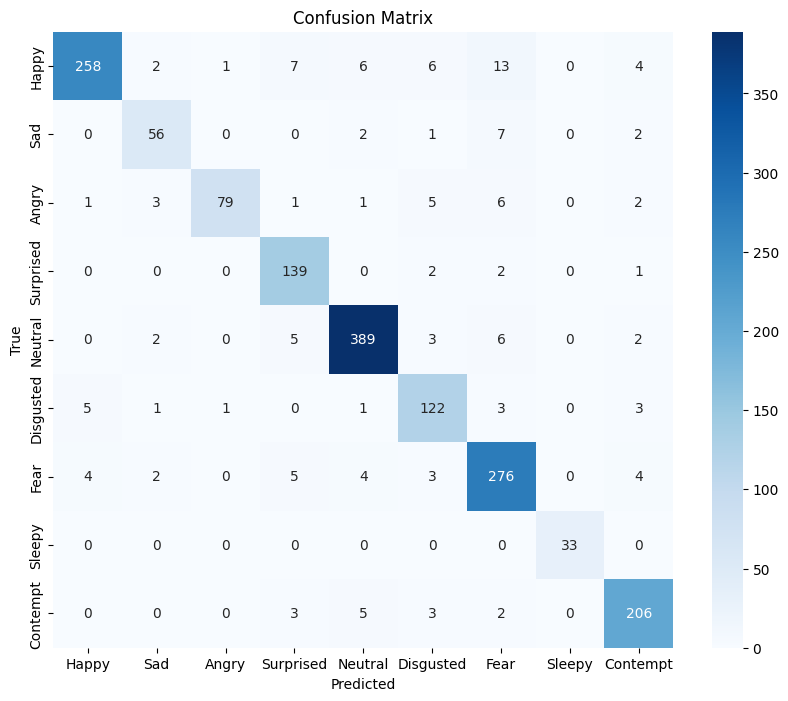

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# ----------------- Predictions -----------------
# Predict class probabilities
y_pred_probs = model.predict(test_images_eff, batch_size=32)
# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(test_labels_categorical, axis=1)

# ----------------- Classification Report -----------------
report = classification_report(y_true, y_pred, target_names=EMOTIONS)
print("Classification Report:\n")
print(report)

# ----------------- Confusion Matrix -----------------
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n")
print(cm)

# Optional: Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=EMOTIONS, yticklabels=EMOTIONS)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
